# Functions

## Load Model

In [264]:
def LoadModel(model, filename, grid, X_train, y_train):
    
    if path.exists(filename):
        return joblib.load(filename)
    else:
        print("No trained model found! Going to create a new one and tune it's hyperparameters (this procedure might take a while!)")
        ## Perform Grid Search to tune the model's hyperparameters

        # GridSearch based on AUROC
        model = GridSearchCV(estimator = model,          
                        param_grid = grid,  
                        scoring = 'roc_auc',           
                        cv = 10, n_jobs=-1, verbose=3)
        # Fit the training data
        model.fit(X_train, y_train)

        # Show the best params
        print("Best hyperparameters found: " , model.best_params_)
        
        best_model=model.best_estimator_
        # Save the best model
        print("Saving the best model!")
        joblib.dump(best_model, filename)
        # Return the best model
        return best_model

## Perform Stratified 10-Fold On Training Set

In [265]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def Perform_CV(model, X, y, cv, plot_ROC_Curves=False):
    
    scoring=['accuracy', 'f1', 'roc_auc', 'recall', 'precision']
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    
    
    acc_values=[]
    f1_values=[]
    roc_auc_values=[]
    recall_values=[]
    precision_values=[]
    
    mean_fpr = np.linspace(0, 1, 100)
    
    # The training set (original  80%) will be splitted into 
    # 10-Stratified Folds (9 will be training, 1 will testing)
    # This allows to ESTIMATE the model's performance on unseen data
    for i, (train, test) in enumerate(cv.split(X, y)):        
        
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        # Fit the new training data
        model.fit(X_train, y_train)
        
        # Make prediction
        y_pred=model.predict(X_test)
        # Make probability predictions
        y_prob=model.predict_proba(X_test)[:,1]
        
        # Compute accuracy score on test set
        acc_values.append(accuracy_score(y_test, y_pred))
        
        # Compute F1 score on test set
        f1_values.append(f1_score(y_test, y_pred))
        
        # Compute AUROC on test set
        roc_auc_values.append(roc_auc_score(y_test, y_prob))
        
        # Generate ROC Curves to plot if it is set to True
        if plot_ROC_Curves is True:
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            
        # Compute Recall on test set
        recall_values.append(recall_score(y_test, y_pred))
                      
        # Compute Precision on test set
        precision_values.append(precision_score(y_test, y_pred))
    
    # Transform into numpy arrays
    acc_values=np.array(acc_values)
    f1_values=np.array(f1_values)
    roc_auc_values=np.array(roc_auc_values)
    recall_values=np.array(recall_values)
    precision_values=np.array(precision_values)
    
    # Print the results
    print("Printing results for test data:\n")                
    print("Accuracy: %0.2f (+/- %0.2f)" % (acc_values.mean(),acc_values.std()*2))
    print("F1: %0.2f (+/- %0.2f)" % (f1_values.mean(),f1_values.std()*2))
    print("AUROC: %0.2f (+/- %0.2f)" % (roc_auc_values.mean(),roc_auc_values.std()*2))
    print("Recall: %0.2f (+/- %0.2f)" % (recall_values.mean(),recall_values.std()*2))
    print("Precision: %0.2f (+/- %0.2f)" % (precision_values.mean(),precision_values.std()*2))
    
    # Display the ROC Curves
    if plot_ROC_Curves is True:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=18)
        plt.ylabel('True Positive Rate',fontsize=18)
        plt.title('Cross-Validation ROC of {}'.format(type(model).__name__),fontsize=18)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()
    

## Make Predictions on Validation Set

In [266]:
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
def Make_Predictions(model, X_val, y_val):
    # Predict output classes
    y_pred = model.predict(X_val)

    # Predict output probs
    y_prob = model.predict_proba(X_val)[:, 1]

    # Displays a report with precision, recall, f1-score, support and accuracy
    print(classification_report(y_val, y_pred,
                                target_names=['Class 0', 'Class 1']))

    # Calculate AUROC (Area under ROC)
    print(f"AUROC: {roc_auc_score(y_val, y_prob)}")
    print(f"Average Precision: {average_precision_score(y_val, y_prob)}")


## Plot ROC Curve on Validation Set

In [267]:
from sklearn.metrics import plot_roc_curve
def Plot_ROC_Curve(model, X_val, y_val):  
    plot_roc_curve(model, X_val, y_val)
    plt.title('Receiver Operating Characteristic {}'.format(type(model).__name__))
    plt.plot([0, 1], [0, 1],'r--')
    plt.show()

# Main Program

In [268]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from os import path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

##  Dataset import, feature selection and data split

In [269]:
# Full features list
feature_names = ['idade', 'Análise Matemática II (14358)', 'Arquitetura de Computadores (14300)', 'Introdução à Engenharia Informática (10276)', 'Inglês II (10366)', 'Laboratório Integrado I (10279)',
                 'Metedologias da Programação I (901)', 'Sistemas Digitais (114)', 'Seminário I (19038)', 'Inglês I (10365)', 'Análise Matemática I (10200)', 'Lógica Computacional (893)', 'Algebra Linear (10192)']

# This features provide the optimal results
best_features = [0, 2, 7, 5, 10, 12]
target_name = ['Desistencia']

# Read the excel info
df = pd.read_excel('output.xlsx')
# Separate the inputs (x -> Students Grades and age) and output (y -> Dropout(1) | Not a dropout(0))
X = df[feature_names].to_numpy()

# Select the best features obtained from the Permutation Feature Importance
X = X[:, best_features]

# Select the output variables
y = df[target_name].to_numpy()
y=y.ravel()

# Split data into train and validation with 80/20 ratio. (It's a stratified split)
# The 20% will be used as a final validation set, it will only be used once at the end.
# The 80% training set will be divided into training and test by the StratifiedKFold object (see below)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=0, stratify=y)

# Define the CrossValidation Object
# This object will be used on the 80% dataset, dividing it into 10 (k) stratified folds.
# 9 folds (k-1) will be used for training, and 1 fold will be used for testing.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

## XGBoost

In [222]:
from xgboost import XGBClassifier

### Load Model

In [223]:
# Hyperparameters grid
grid = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
         "max_depth"        : [ 3, 4, 5, 6,7, 8, 9, 10],
         "min_child_weight" : [ 1, 3, 5, 7 ],
         "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }
# File name
filename='xgb_trained_model.joblib'
# Default model
default_model=XGBClassifier(random_state=0, scale_pos_weight=1.67)
# Load the model
clf_xgb = LoadModel(model=default_model, filename=filename, X_train=X_train, y_train=y_train, grid=grid)


### Evaluate Model
After we loaded the model it's time to evaluate it using StratifiedKFold(k=10).
This is only performed on the 80% of the original dataset.

Printing results for test data:

Accuracy: 0.85 (+/- 0.16)
F1: 0.80 (+/- 0.23)
AUROC: 0.91 (+/- 0.11)
Recall: 0.83 (+/- 0.30)
Precision: 0.78 (+/- 0.25)


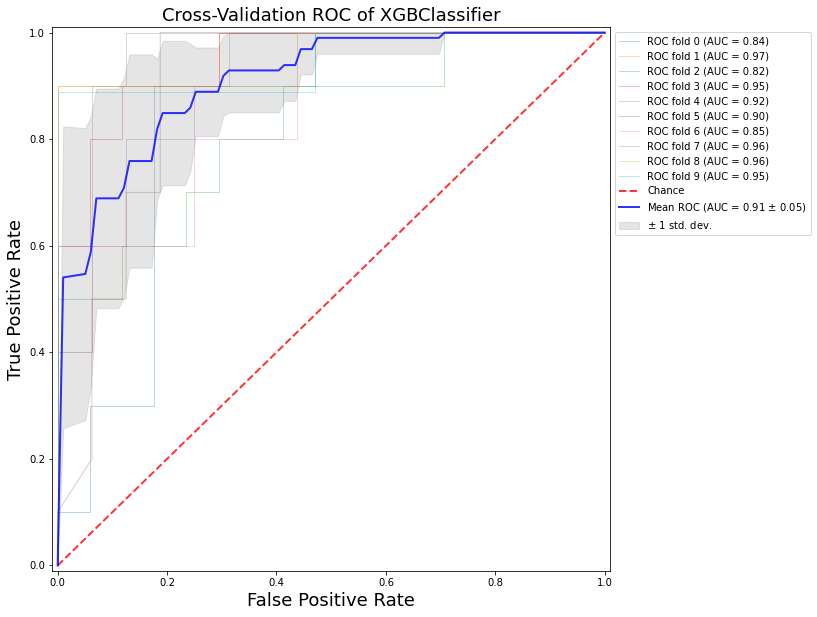

In [224]:
Perform_CV(clf_xgb, X_train, y_train, cv, plot_ROC_Curves=True)

### Evaluate Model on Validation Set

In [225]:
Make_Predictions(clf_xgb, X_val, y_val)

              precision    recall  f1-score   support

     Class 0       0.95      0.88      0.91        42
     Class 1       0.82      0.92      0.87        25

    accuracy                           0.90        67
   macro avg       0.89      0.90      0.89        67
weighted avg       0.90      0.90      0.90        67

AUROC: 0.9514285714285715
Average Precision: 0.9230951628082062


### Plot ROC Curve for Validation Set

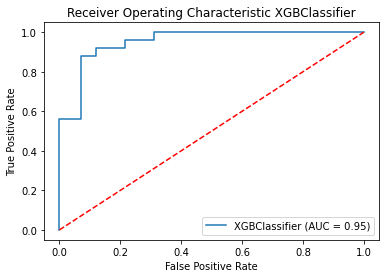

In [211]:
Plot_ROC_Curve(clf_xgb, X_val, y_val)

## CatBoost

In [212]:
from catboost import CatBoostClassifier

### Load Model

In [213]:
# Hyperparameters grid
grid = {'learning_rate': [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 0.9],
        'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15],
        'iterations': [50, 150, 250, 350, 450, 600, 800, 1000]}
# File name
filename='catboost_trained_model.joblib'
# Default model
default_model=CatBoostClassifier(leaf_estimation_iterations=1, border_count=252, scale_pos_weight=1.67)
# Load model
clf_catboost=LoadModel(model=default_model, filename=filename, X_train=X_train, y_train=y_train, grid=grid)

### Evaluate Model
After we loaded the model it's time to evaluate it using StratifiedKFold(k=10).
This is only performed on the 80% of the original dataset.

0:	learn: 0.6729806	total: 592us	remaining: 29ms
49:	learn: 0.9523231	total: 8.98ms	remaining: 0us
0:	learn: 0.7435469	total: 420us	remaining: 20.6ms
49:	learn: 0.9406316	total: 8.62ms	remaining: 0us
0:	learn: 0.7132554	total: 499us	remaining: 24.5ms
49:	learn: 0.9539174	total: 8.68ms	remaining: 0us
0:	learn: 0.7413073	total: 465us	remaining: 22.8ms
49:	learn: 0.9460219	total: 8.5ms	remaining: 0us
0:	learn: 0.7578614	total: 416us	remaining: 20.4ms
49:	learn: 0.9448382	total: 9.34ms	remaining: 0us
0:	learn: 0.7744891	total: 486us	remaining: 23.8ms
49:	learn: 0.9473645	total: 8.58ms	remaining: 0us
0:	learn: 0.7566926	total: 435us	remaining: 21.3ms
49:	learn: 0.9475530	total: 8.71ms	remaining: 0us
0:	learn: 0.7477189	total: 517us	remaining: 25.4ms
49:	learn: 0.9452153	total: 8.46ms	remaining: 0us
0:	learn: 0.7456828	total: 598us	remaining: 29.3ms
49:	learn: 0.9422366	total: 8.63ms	remaining: 0us
0:	learn: 0.7298799	total: 431us	remaining: 21.2ms
49:	learn: 0.9423048	total: 8.35ms	remainin

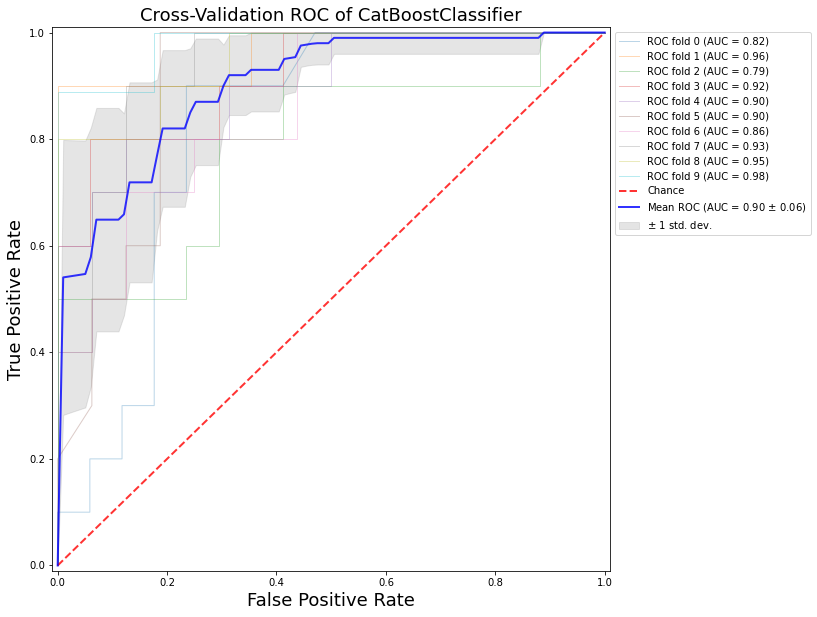

In [214]:
Perform_CV(clf_catboost, X_train, y_train, cv, plot_ROC_Curves=True)

### Evaluate Model on Validation Set

In [215]:
Make_Predictions(clf_catboost, X_val, y_val)

              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90        42
     Class 1       0.84      0.84      0.84        25

    accuracy                           0.88        67
   macro avg       0.87      0.87      0.87        67
weighted avg       0.88      0.88      0.88        67

AUROC: 0.9485714285714285
Average Precision: 0.9183153604327519


### Plot ROC Curve for Validation Set

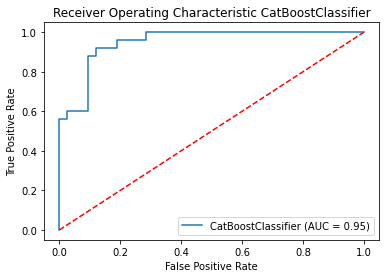

In [216]:
Plot_ROC_Curve(clf_catboost, X_val, y_val)

## Random Forest

In [217]:
from sklearn.ensemble import RandomForestClassifier

### Load Model

In [218]:
# Hyperparameters grid
grid = {'bootstrap': [True, False],
        'max_depth': [1, 2,3,4,5, 6,7,8,9, 10],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [50,100, 200, 400, 600, 800, 1000, 1200, 1400]}
# File name
filename='randomforest_trained_model.joblib'
# Default model
default_model=RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 1.67})
# Load model
clf_rf=LoadModel(model=default_model, filename=filename, X_train=X_train, y_train=y_train, grid=grid)

### Evaluate Model
After we loaded the model it's time to evaluate it using StratifiedKFold(k=10).
This is only performed on the 80% of the original dataset.### Evaluate Model

Printing results for test data:

Accuracy: 0.86 (+/- 0.15)
F1: 0.81 (+/- 0.22)
AUROC: 0.91 (+/- 0.10)
Recall: 0.81 (+/- 0.29)
Precision: 0.81 (+/- 0.21)


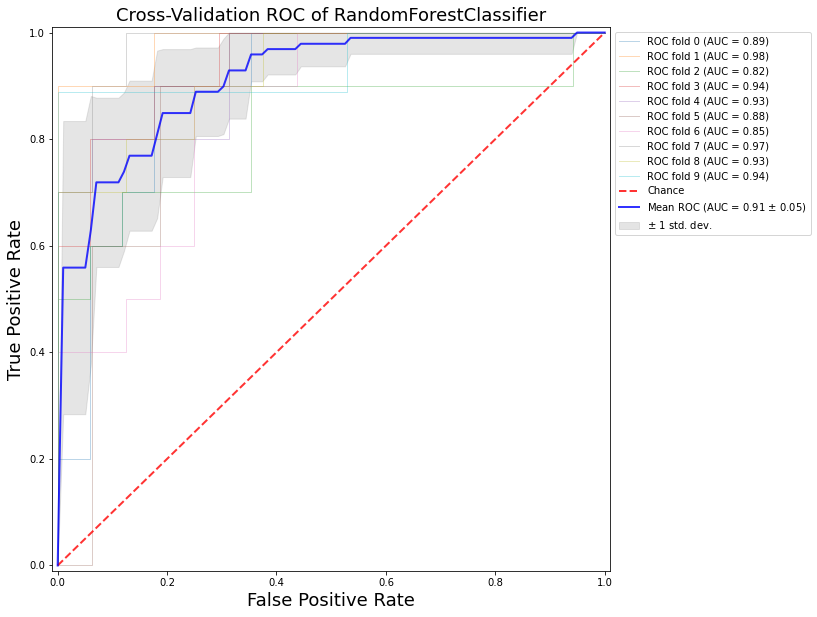

In [219]:
Perform_CV(clf_rf, X_train, y_train, cv, plot_ROC_Curves=True)

### Evaluate Model on Validation Set

In [220]:
print(clf_rf)
Make_Predictions(clf_rf, X_val, y_val)

RandomForestClassifier(class_weight={0: 1, 1: 1.67}, max_depth=7,
                       min_samples_leaf=2, min_samples_split=10,
                       random_state=0)
              precision    recall  f1-score   support

     Class 0       0.93      0.88      0.90        42
     Class 1       0.81      0.88      0.85        25

    accuracy                           0.88        67
   macro avg       0.87      0.88      0.87        67
weighted avg       0.88      0.88      0.88        67

AUROC: 0.9552380952380952
Average Precision: 0.9296506154168893


### Plot ROC Curve for Validation Set

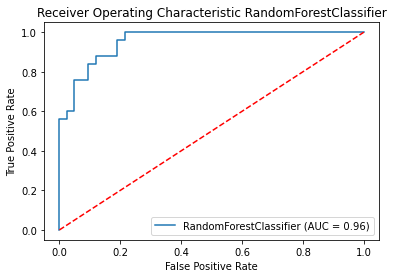

In [221]:
Plot_ROC_Curve(clf_rf, X_val, y_val)

## Artificial Neural Network (ANN)

In [197]:
from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

### Load Model

In [198]:
# Hyperparameters grid
grid = {'nn__solver': ['lbfgs','adam'],
        'nn__activation' : ['logistic', 'relu'],
        'nn__max_iter': [200,300, 400,500,600, 700],
        'nn__learning_rate_init' : [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 0.9],
        'nn__alpha': 10.0 ** -np.arange(1, 10),
        'nn__hidden_layer_sizes':np.arange(7, 14)
        }
# File name
filename='neural_network_trained_model.joblib'
# Default model (pipeline)
default_model=Pipeline([('ss', MinMaxScaler()), ('rus', RandomOverSampler()), ('nn', MLPClassifier(early_stopping=True, random_state=0))])
# Load model
clf_nn=LoadModel(model=default_model, filename=filename, X_train=X_train, y_train=y_train, grid=grid)


### Evaluate Model
After we loaded the model it's time to evaluate it using StratifiedKFold(k=10).
This is only performed on the 80% of the original dataset.

Printing results for test data:

Accuracy: 0.83 (+/- 0.14)
F1: 0.75 (+/- 0.23)
AUROC: 0.92 (+/- 0.09)
Recall: 0.71 (+/- 0.38)
Precision: 0.85 (+/- 0.28)


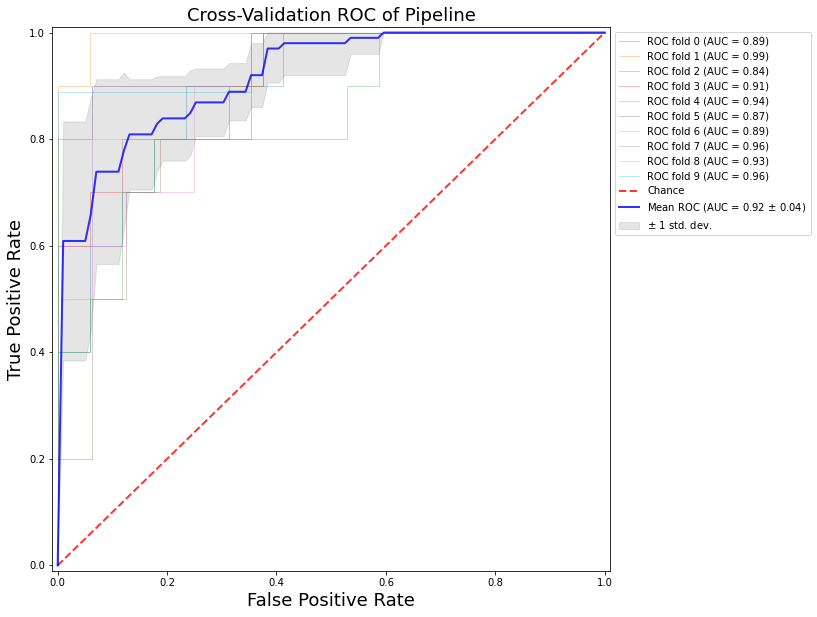

In [199]:
Perform_CV(clf_nn, X_train, y_train, cv, plot_ROC_Curves=True)

### Evaluate Model on Validation Set

In [200]:
Make_Predictions(clf_nn, X_val, y_val)

              precision    recall  f1-score   support

     Class 0       0.88      0.86      0.87        42
     Class 1       0.77      0.80      0.78        25

    accuracy                           0.84        67
   macro avg       0.82      0.83      0.83        67
weighted avg       0.84      0.84      0.84        67

AUROC: 0.939047619047619
Average Precision: 0.9016338958861785


### Plot ROC Curve for Validation Set

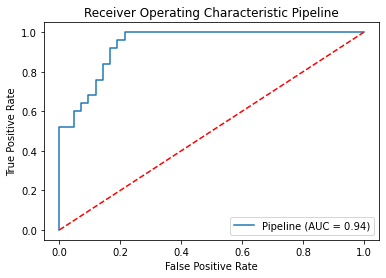

In [201]:
Plot_ROC_Curve(clf_nn, X_val, y_val)